#The Validity of the SoVi Index
###Seth E.  Spielman, David Folch, Joseph Tuccillo

This is a script to calculate the Social Vulnerability (Sovi) Index at multiple geographic scales and usign different sets of input variables.  The Sovi index assess a places social vulnerability to natural hazards and has been used in hundreds of publications, in both the academic and policy domains.  We show that this index fails to meet certain intuitive assumptions about the nature of measurement of social vulnerability.

The aim is to illustrate instability in the index and problems with *convergent validity*.  Convergent Validity is the idea that multiple measurements of the same thing, using a valid instruments, should yield similar *absolute* and *relative* measurements.  For example two thermometers measuing the same cup of water should yield the same approximate temperature- this would be an example of validitiy of absolute measurement.  An less rigorous concept of validity is to consider three cups ordered from hottest (_**A**_) to coldest (_**C**_), the two thermometers would be valid in a *relative* sense if their measurements of cups A, B, C differed absolutely (they measured different temperatures for each cup) but still placed cup _**A**_ as the warmest and cup _**C**_ as the coldest.

We will show in this analysis that the Sovi Index fails this "cup test" that is it often mixes up the orders of the cup.  Counties in the United States that are high vulnerability at one scale of measurement (or form the index) are often low vulnerability in a slightly different version of the index.

##Variables and Components
The Sovi Index is constructed using a tecnhnique called Principal Components Analysis, this is matrix decomposition method that uses the covariance matrix of the input data.  Usually, in the social sciences one treats the "compents" what come of out a PCA as latent variables.  For example, in Sovi it comon to fine components that measure things like "race and class".  In this analysis we also show that this latent variable approach has maked some underlying problems with the Soci index, namely that variables contribute to the index in ways that are profoundly counter intuitive.  

##There is a paper
For an in-depth discussion of these ideas please see the companion paper to this anlysis [URL]() or contact the suthors. 

##Data Prep

In this section we read in data from the American Community Survey and the Decennial Census and processes the varaibles such that they correspond to the inputs used to commonly construct the Sovi Index,  There is **a lot of data wrangling here**, combining variables into new variables, computing standard errors, etc.  Its all farily straightforward and I will not talk through the details here.

In [74]:
import os
import pandas as pd
import pysal as ps
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats.mstats import zscore as ZSCORE
from scipy.stats import rankdata
from scipy.stats import spearmanr 
from spss_pca import SPSS_PCA

local_path = '/Users/Seth/'
#local_path = '/Users/dfolch/'

os.chdir(local_path+'Dropbox/SoVI_var_wise_paper/code')
path=local_path+'/Dropbox/SoVI_var_wise_paper'
outPath =local_path+'/Dropbox/SoVI_var_wise_paper/data'

###Functions for calculating Standard Errors

THe functions below are to calculate the standard error (SE) of various types of estimates from the American Cummunity Survey.  These are provided by the US Census Bureau in the ACS Techncial Documentation.

In [75]:
#SE of a sum
def se_sum(*ses):
    df_temp = pd.DataFrame(list(ses))
    df_temp = df_temp.T
    df_temp = np.square(df_temp)
    df_temp = df_temp.sum(1)
    return np.sqrt(df_temp)

#SE of a ratio
def se_ratio(est, estd, sen, sed):
    sen2 = np.square(sen)
    sed2 = np.square(sed)
    est2 = np.square(est)
    num = np.sqrt(sen2 + (est2*sed2))
    return num / estd

#SE of a proprotion
def se_prop(est, estd, sen, sed):
    sen2 = np.square(sen)
    sed2 = np.square(sed)
    est2 = np.square(est)
    num = sen2 - (est2*sed2)
    num_alt = sen2 + (est2*sed2)
    problems = num <= 0
    num[problems] = num_alt[problems]
    num = np.sqrt(num)
    return num / estd

### Loading Input Data

In [76]:
#%%capture capt
pd.set_option("chained_assignment", None)

path=local_path+"Dropbox/SoVI_var_wise_paper/data/input"
spath=local_path+"Dropbox/SoVI_var_wise_paper/data/spatial"

make_strings = {'Geo_FIPS':object, 'Geo_STATE':object, 'Geo_COUNTY':object, 
                'Geo_TRACT':object, 'Geo_CBSA':object, 'Geo_CSA':object}
acs = pd.read_csv(os.path.join(path,'sovi_acs.csv'), dtype=make_strings, skiprows=1)
acs.index = 'g' + acs.Geo_FIPS
census = pd.read_csv(os.path.join(path,'sovi_decennial.csv'), dtype=make_strings, skiprows=1)
census.index = 'g' + census.Geo_FIPS
db = census
db = db.join(acs, rsuffix='_acs')

acs_samp = pd.read_csv(os.path.join(path,'sovi_acs_sampSize.csv'), dtype=make_strings, skiprows=1)
acs_samp.index = 'g' + acs_samp.Geo_FIPS
db = db.join(acs_samp, rsuffix='_acsSamp')

try:
    census_sup1 = pd.read_csv(os.path.join(path,'sovi_decennial_sup1.csv'), dtype=make_strings, skiprows=1)
    census_sup1.index = 'g' + census_sup1.Geo_FIPS
    db = db.join(census_sup1, rsuffix='_decSup1')
except:
    print 'no supplementary decennial data'
try:
    acs_sup1 = pd.read_csv(os.path.join(spath,'sovi_acs_sup1.csv'), dtype=make_strings, skiprows=1)
    acs_sup1.index = 'g' + acs_sup1.Geo_FIPS
    db = db.join(acs_sup1, rsuffix='_acsSup1')
except:
    print 'did not pull supplementary ACS data - A'
try:
    acs_sup2 = pd.read_csv(os.path.join(path,'sovi_acs_kids.csv'), dtype=make_strings, skiprows=1)
    acs_sup2.index = 'g' + acs_sup2.Geo_FIPS
    db = db.join(acs_sup2, rsuffix='_acsSup2')
except:
    print 'did not pull supplementary ACS data - B'
    
# drop Puerto Rico (sorry PR!)
db = db[db.Geo_STATE != '72']

did not pull supplementary ACS data - A


###Preparing Sovi Inputs and Calculating SE

A few counties are missing data so we create imput the values for these counties by taking the average value of their neighbors.  This is done using the spatial weights matrix `w`.

In [77]:
#%%capture capt

# cleanup Social Explorer standard errors
se_cols = [i for i in db.columns if i[-1]=='s' and i[0]=='A']
db[se_cols] *= (1.65/1.645)

# weights matrix for computing spatial lags of missing data
w = ps.queen_from_shapefile(os.path.join(spath,'USA_Counties_500k.shp'), idVariable='geoFIPS')
w.transform = 'R'


# output dataframe
db1 = pd.DataFrame(index=db.index)

# Decennial variables (original)
db1['MEDAGE']  =  db.SF1_P0130001
db1['BLACK']   = (db.SF1_P0030003 * 1.) / db.SF1_P0010001
db1['QNATAM']  = (db.SF1_P0030004 * 1.) / db.SF1_P0010001
db1['QASIAN']  = (db.SF1_P0030005 * 1.) / db.SF1_P0010001
db1['QHISP']   = (db.SF1_P0040003 * 1.) / db.SF1_P0010001
db1['QAGEDEP'] =((db.SF1_P0120003 + db.SF1_P0120027 + db.SF1_P0120020 + 
                  db.SF1_P0120021 + db.SF1_P0120022 + db.SF1_P0120023 + 
                  db.SF1_P0120024 + db.SF1_P0120025 + db.SF1_P0120044 + 
                  db.SF1_P0120045 + db.SF1_P0120046 + db.SF1_P0120047 + 
                  db.SF1_P0120048 + db.SF1_P0120049) * 1.) / db.SF1_P0010001
db1['PPUNIT']  =  db.SF1_H0100001 / (db.SF1_H0030002 * 1.)
db1['PRENTER'] = (db.SF1_H0040004 * 1.) / db.SF1_H0010001
db1['QNRRES']  = (db.SF1_P0420005 * 1.) / db.SF1_P0010001
db1['QFEMALE'] = (db.SF1_P0120026 * 1.) / db.SF1_P0010001
db1['QFHH']    = (db.SF1_P0190014 * 1.) / db.SF1_P0180001
db1['QUNOCCHU']=((db.SF1_H0010001 - db.SF1_H0030002) * 1.) / db.SF1_H0010001

# Decennial variables (alternatives)
db1['BLACK_ALT']   = (db.SF1_P0050004 * 1.) / db.SF1_P0010001 # exclude hispanic
db1['QNATAM_ALT']  = (db.SF1_P0050005 * 1.) / db.SF1_P0010001 # exclude hispanic
db1['QASIAN_ALT']  = (db.SF1_P0050006 * 1.) / db.SF1_P0010001 # exclude hispanic
db1['QNRRES_ALT']  = (db.SF1_P0430023 + db.SF1_P0430054 * 1.) / db.SF1_P0010001 # 65 and over living in group quarters
db1['QUNOCCHU_ALT']= (db.SF1_H0030003 * 1.) / db.SF1_H0030001  # same value, simplified computation

# Decennial variables (using ACS data and alternative formulations)
db1['MEDAGE_ACS']  = db.ACS12_5yr_B01002001
db1['BLACK_ACS']   = db.ACS12_5yr_B03002004 / (db.ACS12_5yr_B03002001 * 1.)
db1['QNATAM_ACS']  = db.ACS12_5yr_B03002005 / (db.ACS12_5yr_B03002001 * 1.)
db1['QASIAN_ACS']  = db.ACS12_5yr_B03002006 / (db.ACS12_5yr_B03002001 * 1.)
db1['QHISP_ACS']   = db.ACS12_5yr_B03002012 / (db.ACS12_5yr_B03002001 * 1.)
db1['QAGEDEP_ACS'] =(db.ACS12_5yr_B06001002 + db.ACS12_5yr_B09020001) / (db.ACS12_5yr_B01003001 * 1.)
db1['QPUNIT_ACS']  = db.ACS12_5yr_B25008001 / (db.ACS12_5yr_B25002002 * 1.)
db1['PRENTER_ACS'] = db.ACS12_5yr_B25003003 / (db.ACS12_5yr_B25002001 * 1.)
db1['QNRRES_ACS']  = db.ACS12_5yr_B09020021 / (db.ACS12_5yr_B01003001 * 1.)
db1['QFEMALE_ACS'] = db.ACS12_5yr_B01001026 / (db.ACS12_5yr_B01003001 * 1.) 
db1['QFHH_ACS']    = db.ACS12_5yr_B11001006 / (db.ACS12_5yr_B11001001 * 1.)
db1['QUNOCCHU_ACS']= db.ACS12_5yr_B25002003 / (db.ACS12_5yr_B25002001 * 1.)





#############################

# ACS variables (original)
db1['PERCAP']   =  db.ACS12_5yr_B19025001 / (db.ACS12_5yr_B01003001 * 1.)
db1['QESL']     =((db.ACS12_5yr_B16004029 + db.ACS12_5yr_B16004030 +
                   db.ACS12_5yr_B16004034 + db.ACS12_5yr_B16004035 +
                   db.ACS12_5yr_B16004039 + db.ACS12_5yr_B16004040 +
                   db.ACS12_5yr_B16004044 + db.ACS12_5yr_B16004045 +
                   db.ACS12_5yr_B16004051 + db.ACS12_5yr_B16004052 +
                   db.ACS12_5yr_B16004056 + db.ACS12_5yr_B16004057 +
                   db.ACS12_5yr_B16004061 + db.ACS12_5yr_B16004062 +
                   db.ACS12_5yr_B16004066 + db.ACS12_5yr_B16004067) * 1.) /\
                 ((db.ACS12_5yr_B16004024 + db.ACS12_5yr_B16004046) - 
                  (db.ACS12_5yr_B16004025 + db.ACS12_5yr_B16004047))
db1.QESL = db1.QESL.replace([np.inf,-np.inf, np.nan], 0)
db1.QESL = db1.QESL.replace([np.inf,-np.inf], 0)
db1['QCVLUN']   =((db.ACS12_5yr_B23022025 + db.ACS12_5yr_B23022049) * 1.) /\
                   db.ACS12_5yr_B23022001
db1['QPOVTY']   = (db.ACS12_5yr_B17021002 * 1.) / db.ACS12_5yr_B17021001
db1['QMOHO']    = (db.ACS12_5yr_B25024010 * 1.) / db.ACS12_5yr_B25024001
db1['QED12LES'] =((db.ACS12_5yr_B15002003 + db.ACS12_5yr_B15002004 +
                   db.ACS12_5yr_B15002005 + db.ACS12_5yr_B15002006 +
                   db.ACS12_5yr_B15002007 + db.ACS12_5yr_B15002008 +
                   db.ACS12_5yr_B15002009 + db.ACS12_5yr_B15002010 +
                   db.ACS12_5yr_B15002020 + db.ACS12_5yr_B15002021 +
                   db.ACS12_5yr_B15002022 + db.ACS12_5yr_B15002023 +
                   db.ACS12_5yr_B15002024 + db.ACS12_5yr_B15002025 +
                   db.ACS12_5yr_B15002026 + db.ACS12_5yr_B15002027) * 1.) /\
                   db.ACS12_5yr_B15002001
db1['QFEMLBR']  = (db.ACS12_5yr_C24010038 * 1.) / db.ACS12_5yr_C24010001
db1['QEXTRCT']  =((db.ACS12_5yr_C24030003 + db.ACS12_5yr_C24030030) * 1.) /\
                   db.ACS12_5yr_C24030001
db1['QSERV']    =((db.ACS12_5yr_C24010019 + db.ACS12_5yr_C24010055) * 1.) /\
                   db.ACS12_5yr_C24010001
db1['QSSBEN']   = (db.ACS12_5yr_B19055002 * 1.) / db.ACS12_5yr_B19055001
db1['QNOAUTO']  =((db.ACS12_5yr_B25044003 + db.ACS12_5yr_B25044010) * 1.) /\
                   db.ACS12_5yr_B25044001
db1['QFAM']     = (db.ACS12_5yr_B09002002 * 1.) / db.ACS12_5yr_B09002001
db1.QFAM = db1.QFAM.replace([np.inf,-np.inf, np.nan], 0)
db1['QRICH200K']= (db.ACS12_5yr_B19001017 * 1.) / db.ACS12_5yr_B11001001

# ACS variables (alternatives)
db1['PERCAP_ALT']   =  db.ACS12_5yr_B19025001 / (db.ACS12_5yr_B25008001 * 1.)  # HH income divided by persons in HHs
db1['QESL_ALT']     =((db.ACS12_5yr_B06007005 + db.ACS12_5yr_B06007008) * 1.) /\
                       db.ACS12_5yr_B06007001                        # 5 and older who don't speak English very well
db1['QED12LES_ALT'] = (db.ACS12_5yr_B16010002 * 1.) / db.ACS12_5yr_B16010001  # same value, simplified computation
db1['QEXTRCT_ALT']  = (db.ACS12_5yr_C24050002 * 1.) / db.ACS12_5yr_C24050001  # same value, simplified computation
db1['QSERV_ALT']    = (db.ACS12_5yr_C24050029 * 1.) / db.ACS12_5yr_C24050001  # same value, simplified computation
db1['QNOAUTO_ALT']  = (db.ACS12_5yr_B08201002 * 1.) / db.ACS12_5yr_B08201001  # same value, simplified computation
db1['MDGRENT_ALT']  =  db.ACS12_5yr_B25064001          # the original computed the median by hand so is not included
db1['MHSEVAL_ALT']  =  db.ACS12_5yr_B25077001          # the original computed the median by hand so is not included
db1['POPDENS']      =  db.ACS12_5yr_B01003001 / (db.SE_T02A_002 * 1.)  # I didn't understand QURBRURX

# if no home value, assign the spatial lag of the estimate and SE
homeval = db1['MHSEVAL_ALT'].copy()
homeval_se = db.ACS12_5yr_B25077001s.copy()
dbf = ps.open(os.path.join(spath,'USA_Counties_500k.dbf'))

#Rename dbf GEOIDs to match homeval
geoid=dbf.by_col('geoFIPS')

shp_fips = pd.DataFrame(dbf.by_col('geoFIPS'), index=geoid)
shp_fips = shp_fips.join(homeval)
shp_fips = shp_fips.join(homeval_se)
shp_fips['MHSEVAL_ALT_LAG'] = ps.lag_spatial(w, shp_fips.MHSEVAL_ALT)
shp_fips['MHSEVAL_ALT_LAG_SE'] = ps.lag_spatial(w, shp_fips.ACS12_5yr_B25077001s)

##Assign MHSEVAL_ALT and MHSEVAL_ALT_SE values back to neighborless counties 
#This might just act as a temporary fix... 

#Get original MHSEVAL_ALT values for problem counties as list
mh=shp_fips.ix[shp_fips.MHSEVAL_ALT_LAG==0].MHSEVAL_ALT.tolist()

#Reassign values to MHSEVAL_ALT_LAG
shp_fips.ix[shp_fips.MHSEVAL_ALT_LAG==0,'MHSEVAL_ALT_LAG']=mh

#Reassign missing standard error values
mhs=shp_fips.ix[shp_fips.MHSEVAL_ALT_LAG_SE==0].ACS12_5yr_B25077001s.tolist()
shp_fips.ix[shp_fips.MHSEVAL_ALT_LAG_SE==0,'MHSEVAL_ALT_LAG_SE']=mhs

#Get rid of nan values - reassign MHSEVAL_ALT(_SE)
shp_fips.MHSEVAL_ALT_LAG[np.isnan(shp_fips.MHSEVAL_ALT_LAG)] = shp_fips.MHSEVAL_ALT[np.isnan(shp_fips.MHSEVAL_ALT_LAG)] # replace NA with lag  
shp_fips.MHSEVAL_ALT_LAG_SE[np.isnan(shp_fips.MHSEVAL_ALT_LAG_SE)] = shp_fips.ACS12_5yr_B25077001s[np.isnan(shp_fips.MHSEVAL_ALT_LAG_SE)] # replace NA with lag  


db1['MHSEVAL_ALT_LAG'] = shp_fips['MHSEVAL_ALT_LAG']
db1['MHSEVAL_ALT_LAG_SE'] = shp_fips['MHSEVAL_ALT_LAG_SE']
db1.MHSEVAL_ALT[np.isnan(db1.MHSEVAL_ALT)] = db1.MHSEVAL_ALT_LAG[np.isnan(db1.MHSEVAL_ALT)]  
# note: the lagged SE is pushed to the final column in the SE section below

#############################

# Decennial standard errors (using ACS data and alternative formulations)
db1['MEDAGE_ACS_SE']  = db.ACS12_5yr_B01002001s

db1['BLACK_ACS_SE']   = se_prop(db1.BLACK_ACS,           db.ACS12_5yr_B03002001,
                                db.ACS12_5yr_B03002004s, db.ACS12_5yr_B03002001s)
db1['QNATAM_ACS_SE']  = se_prop(db1.QNATAM_ACS,          db.ACS12_5yr_B03002001,
                                db.ACS12_5yr_B03002005s, db.ACS12_5yr_B03002001s)
db1['QASIAN_ACS_SE']  = se_prop(db1.QASIAN_ACS,          db.ACS12_5yr_B03002001,
                                db.ACS12_5yr_B03002006s, db.ACS12_5yr_B03002001s)
db1['QHISP_ACS_SE']   = se_prop(db1.QHISP_ACS,           db.ACS12_5yr_B03002001,
                                db.ACS12_5yr_B03002012s, db.ACS12_5yr_B03002001s)

QAGEDEP_ACS_sen       = se_sum(db.ACS12_5yr_B06001002s, db.ACS12_5yr_B09020001s)
db1['QAGEDEP_ACS_SE'] = se_prop(db1.QAGEDEP_ACS, db.ACS12_5yr_B01003001,
                                QAGEDEP_ACS_sen, db.ACS12_5yr_B01003001s)

db1['QPUNIT_ACS_SE']  =se_ratio(db1.QPUNIT_ACS,          db.ACS12_5yr_B25002002,
                                db.ACS12_5yr_B25008001s, db.ACS12_5yr_B25002002s)
db1['PRENTER_ACS_SE'] = se_prop(db1.PRENTER_ACS,         db.ACS12_5yr_B25002001,
                                db.ACS12_5yr_B25003003s, db.ACS12_5yr_B25002001s)
db1['QNRRES_ACS_SE']  = se_prop(db1.QNRRES_ACS,          db.ACS12_5yr_B01003001,
                                db.ACS12_5yr_B09020021s, db.ACS12_5yr_B01003001s)
db1['QFEMALE_ACS_SE'] = se_prop(db1.QFEMALE_ACS,         db.ACS12_5yr_B01003001,
                                db.ACS12_5yr_B01001026s, db.ACS12_5yr_B01003001s) 
db1['QFHH_ACS_SE']    = se_prop(db1.QFHH_ACS,            db.ACS12_5yr_B11001001,
                                db.ACS12_5yr_B11001006s, db.ACS12_5yr_B11001001s)
db1['QUNOCCHU_ACS_SE']= se_prop(db1.QUNOCCHU_ACS,        db.ACS12_5yr_B25002001,
                                db.ACS12_5yr_B25002003s, db.ACS12_5yr_B25002001s)





#############################

# ACS standard errors (original)
db1['PERCAP_SE']   = se_ratio(db1.PERCAP,              db.ACS12_5yr_B01003001,
                              db.ACS12_5yr_B19025001s, db.ACS12_5yr_B01003001s)

QESL_sen           = se_sum(db.ACS12_5yr_B16004029s, db.ACS12_5yr_B16004030s,
                            db.ACS12_5yr_B16004034s, db.ACS12_5yr_B16004035s,
                            db.ACS12_5yr_B16004039s, db.ACS12_5yr_B16004040s,
                            db.ACS12_5yr_B16004044s, db.ACS12_5yr_B16004045s,
                            db.ACS12_5yr_B16004051s, db.ACS12_5yr_B16004052s,
                            db.ACS12_5yr_B16004056s, db.ACS12_5yr_B16004057s,
                            db.ACS12_5yr_B16004061s, db.ACS12_5yr_B16004062s,
                            db.ACS12_5yr_B16004066s, db.ACS12_5yr_B16004067s)
QESL_sed           = se_sum(db.ACS12_5yr_B16004024s, db.ACS12_5yr_B16004046s,
                            db.ACS12_5yr_B16004025s, db.ACS12_5yr_B16004047s)
db1['QESL_SE']     = se_prop(db1.QESL, (db.ACS12_5yr_B16004024 + db.ACS12_5yr_B16004046) - 
                                       (db.ACS12_5yr_B16004025 + db.ACS12_5yr_B16004047),
                             QESL_sen, QESL_sed)
db1.QESL_SE = db1.QESL_SE.replace([np.inf,-np.inf], 0)
db1.QESL_SE[db1.QESL==0] = 0

QCVLUN_sen         = se_sum(db.ACS12_5yr_B23022025s, db.ACS12_5yr_B23022049s)
db1['QCVLUN_SE']   = se_prop(db1.QCVLUN, db.ACS12_5yr_B23022001, 
                             QCVLUN_sen, db.ACS12_5yr_B23022001s)

db1['QPOVTY_SE']   = se_prop(db1.QPOVTY,              db.ACS12_5yr_B17021001,
                             db.ACS12_5yr_B17021002s, db.ACS12_5yr_B17021001s)
db1['QMOHO_SE']    = se_prop(db1.QMOHO,               db.ACS12_5yr_B25024001,
                             db.ACS12_5yr_B25024010s, db.ACS12_5yr_B25024001s)

QED12LES_sen       = se_sum(db.ACS12_5yr_B15002003s, db.ACS12_5yr_B15002004s,
                            db.ACS12_5yr_B15002005s, db.ACS12_5yr_B15002006s,
                            db.ACS12_5yr_B15002007s, db.ACS12_5yr_B15002008s,
                            db.ACS12_5yr_B15002009s, db.ACS12_5yr_B15002010s,
                            db.ACS12_5yr_B15002020s, db.ACS12_5yr_B15002021s,
                            db.ACS12_5yr_B15002022s, db.ACS12_5yr_B15002023s,
                            db.ACS12_5yr_B15002024s, db.ACS12_5yr_B15002025s,
                            db.ACS12_5yr_B15002026s, db.ACS12_5yr_B15002027s)
db1['QED12LES_SE'] = se_prop(db1.QED12LES, db.ACS12_5yr_B15002001,
                             QED12LES_sen, db.ACS12_5yr_B15002001s)

db1['QFEMLBR_SE']  = se_prop(db1.QFEMLBR,             db.ACS12_5yr_C24010001,
                             db.ACS12_5yr_C24010038s, db.ACS12_5yr_C24010001s)


QEXTRCT_sen        = se_sum(db.ACS12_5yr_C24030003s, db.ACS12_5yr_C24030030s)
db1['QEXTRCT_SE']  = se_prop(db1.QEXTRCT, db.ACS12_5yr_C24030001,
                             QEXTRCT_sen, db.ACS12_5yr_C24030001s)

QSERV_sen          = se_sum(db.ACS12_5yr_C24010019s, db.ACS12_5yr_C24010055s)
db1['QSERV_SE']    = se_prop(db1.QSERV, db.ACS12_5yr_C24010001,
                             QSERV_sen, db.ACS12_5yr_C24010001s)

db1['QSSBEN_SE']   = se_prop(db1.QSSBEN,              db.ACS12_5yr_B19055001, 
                             db.ACS12_5yr_B19055002s, db.ACS12_5yr_B19055001s)

QNOAUTO_sen        = se_sum(db.ACS12_5yr_B25044003s, db.ACS12_5yr_B25044010s)
db1['QNOAUTO_SE']  = se_prop(db1.QNOAUTO, db.ACS12_5yr_B25044001,
                             QNOAUTO_sen, db.ACS12_5yr_B25044001s)

db1['QFAM_SE']     = se_prop(db1.QFAM,                db.ACS12_5yr_B09002001, 
                             db.ACS12_5yr_B09002002s, db.ACS12_5yr_B09002001s)
db1.QFAM_SE = db1.QFAM_SE.replace([np.inf,-np.inf], 0)

db1['QRICH200K_SE']= se_prop(db1.QRICH200K,           db.ACS12_5yr_B11001001, 
                             db.ACS12_5yr_B19001017s, db.ACS12_5yr_B11001001s)


#############################

# ACS standard errors (alternatives)
db1['PERCAP_ALT_SE']   =  se_ratio(db1.PERCAP_ALT,          db.ACS12_5yr_B25008001,
                                   db.ACS12_5yr_B19025001s, db.ACS12_5yr_B25008001s)

QESL_ALT_sen           = se_sum(db.ACS12_5yr_B06007005s, db.ACS12_5yr_B06007008s)
db1['QESL_ALT_SE']     = se_prop(db1.QESL_ALT, db.ACS12_5yr_B06007001,
                                 QESL_ALT_sen, db.ACS12_5yr_B06007001s)

db1['QED12LES_ALT_SE'] = se_prop(db1.QED12LES_ALT,        db.ACS12_5yr_B16010001,
                                 db.ACS12_5yr_B16010002s, db.ACS12_5yr_B16010001s)
db1['QEXTRCT_ALT_SE']  = se_prop(db1.QEXTRCT_ALT,         db.ACS12_5yr_C24050001,
                                 db.ACS12_5yr_C24050002s, db.ACS12_5yr_C24050001s)
db1['QSERV_ALT_SE']    = se_prop(db1.QSERV_ALT,           db.ACS12_5yr_C24050001,
                                 db.ACS12_5yr_C24050029s, db.ACS12_5yr_C24050001s)
db1['QNOAUTO_ALT_SE']  = se_prop(db1.QNOAUTO_ALT,         db.ACS12_5yr_B08201001,
                                 db.ACS12_5yr_B08201002s, db.ACS12_5yr_B08201001s)
db1['MDGRENT_ALT_SE']  =  db.ACS12_5yr_B25064001s
db1['MHSEVAL_ALT_SE']  =  db.ACS12_5yr_B25077001s
db1.MHSEVAL_ALT_SE[np.isnan(db1.MHSEVAL_ALT)] = db1.MHSEVAL_ALT_LAG_SE[np.isnan(db1.MHSEVAL_ALT)] # replace NA with lag  
db1.MHSEVAL_ALT_SE[np.isnan(db1.MHSEVAL_ALT_SE)] = db1.MHSEVAL_ALT_LAG_SE[np.isnan(db1.MHSEVAL_ALT_SE)] # replace NA with lag  
db1['POPDENS_SE']      =se_ratio(db1.POPDENS,             db.SE_T02A_002,
                                 db.ACS12_5yr_B01003001s, 0)  # these are nearly all zero since county pops tend to have 0 MOE

#############################

# Tests to validate equivalency 
def equal_test(orig, alt):
    if np.equal(orig, alt).sum() != db.shape[0]:
        if (db.shape[0] - np.equal(orig, alt).sum()) == np.isnan(orig).sum() == np.isnan(alt).sum():
            pass
        else:
            raise Exception, 'problem'
equal_test(db1.QUNOCCHU, db1.QUNOCCHU_ALT)
equal_test(db1.QED12LES, db1.QED12LES_ALT)
equal_test(db1.QEXTRCT,  db1.QEXTRCT_ALT)
equal_test(db1.QSERV,    db1.QSERV_ALT)        
equal_test(db1.QNOAUTO,  db1.QNOAUTO_ALT)    



#############################

# Add in the sample sizes
db1['sample_person']  =  db.ACS12_5yr_B00001001
db1['sample_hu']  =  db.ACS12_5yr_B00002001

#############################

#the final data frame is written to disk
db1.to_csv(os.path.join(path,'sovi_inputs.csv'))

Island ids:  [68, 546, 547, 549, 1226, 1876, 2976]


###Analysis

Here we load the data `db1` or alternative add a refernce to db1 with a new name `US_ALL`. We describe each of the input variables with a human readable name and outline their expected contributions to vulnerability.  For example, the variable `MEDAGE_ACS`, which measures the median age in the county is expected to have a positive ("pos") contribution to social vulnerability - the logic is that older populations are more vulnerable to disasters.   Similarly the variable `QRICH200K`, which measures the portion of hosuing units making over $200k/year is expected to have a negative ("neg") contribution to social vulnerability.   

In [78]:
#Import Data
US_All = db1.copy()
US_All['Geo_FIPS'] = US_All.index.values
#US_All = pd.read_csv(path+'/data/input/sovi_inputs.csv')
#US_All.index = US_All.Geo_FIPS


# attribute name and expected influence on vulnerability
input_names = [['MEDAGE_ACS','pos','person'],
               ['BLACK_ACS','pos','person'],   
               ['QNATAM_ACS','pos','person'],  
               ['QASIAN_ACS','pos','person'],  
               ['QHISP_ACS','pos','person'],   
               ['QAGEDEP_ACS','pos','person'], 
               ['QPUNIT_ACS','pos','person'],  
               ['PRENTER_ACS','pos','hu'], 
               ['QNRRES_ACS','pos','person'],  
               ['QFEMALE_ACS','pos','person'], 
               ['QFHH_ACS','pos','hu'],    
               ['QUNOCCHU_ACS','pos','hu'],
               ['PERCAP_ALT','neg','person'],  
               ['QESL_ALT','pos','person'],    
               ['QCVLUN','pos','person'], 
               ['QPOVTY','pos','person'],
               ['QMOHO','pos','hu'],
               ['QED12LES_ALT','pos','person'],
               ['QFEMLBR','pos','person'], 
               ['QEXTRCT_ALT','pos','person'], 
               ['QSERV_ALT','pos','person'],   
               ['QSSBEN','pos','hu'],
               ['QNOAUTO_ALT','pos','hu'], 
               ['QFAM','neg','person'], 
               ['QRICH200K','neg','hu'],
               ['MDGRENT_ALT','neg','hu'], 
               ['MHSEVAL_ALT','neg','hu'], 
               ['POPDENS','pos','person']] 

#Get attribute names
attr_names=[j[0] for j in input_names]
#cols = [c for c in US_All.columns if c.find('_SE') == -1]

attr_names.append('Geo_FIPS')
#US_All = US_All.dropna(axis=0) #two counties misisng data in state 15 and 48
US_All = US_All[attr_names]
US_All['stateID'] = US_All.Geo_FIPS.str.slice(0,3,1)
attr_names.remove('Geo_FIPS')

####Flipping Signs

To ensure that each variable contributes as expected to the final Sovi Index following Eric Tate (2012?) we flip the signs of the input data.  Variables where a high value are expected to contribute negatively to Social vulnerability have their signs flipped, such that positive values become negative.  This has the effect of reversing the sign of the scores used to compute the index.  Consider the variable measuring the percent of households making over \$200,000 per year, if the mean at the county-level in a state was 5\% a county two SD above the mean, say one where 10\% of the population made mroe than $200K, that would have a positive z-score (+2).  However, this high prevalance of wealthy people should reduce the vulnerability, by flipping the signs we ensure that that mean is now -5\% and a value of -10\% is two standard deviations *below* the mean.  Thus when multiplied by its (positive) loading a county whit high wealth will have a lower social vulnerability index.

In [79]:
# input data prep
# --swap signs of the attributes expected to have a "negative" affect on vulnerability
for name, sign, sample in input_names:
    if sign == 'neg':
        US_All[name] = -US_All[name].values
    elif sign == 'pos':
        pass
    else:
        raise Exception, "problem"

## Subset FEMA Regions and Calculate SOVI

In [80]:
########################################
##SOVI FOR FEMA REGIONS
#########################################
#Build FEMA subRegions Dict values= state ID's
FEMA_subs= {'FEMA_1':['g23','g50','g33','g25','g09','g44']}
FEMA_subs['FEMA_2'] = ['g36','g34']
FEMA_subs['FEMA_3'] = ['g42','g10','g11','g24','g51','g54']
FEMA_subs['FEMA_4'] = ['g21','g47','g37','g28','g01','g13','g45','g12']
FEMA_subs['FEMA_5'] = ['g27','g55','g26','g17','g18','g39']
FEMA_subs['FEMA_6'] = ['g35','g48','g40','g05','g22']
FEMA_subs['FEMA_7'] = ['g31','g19','g20','g29']
FEMA_subs['FEMA_8'] = ['g30','g38','g56','g46','g49','g08']
FEMA_subs['FEMA_9'] = ['g06','g32','g04']
FEMA_subs['FEMA_10'] = ['g53','g41','g16']

#Dict to hold variable loadings
varContrib = {}

#Multiindexed DataFrame to hold all FEMA SOVI Scores
geoLevels = US_All.Geo_FIPS
femaLevels = FEMA_subs.keys()
geoLabels = []
femaLabels = []
for f in femaLevels:
    femaRegionIndexes = US_All[US_All['stateID'].isin(FEMA_subs[f])].index.values
    geoLabels.extend([US_All.index.get_loc(i) for i in femaRegionIndexes])
    femaLabels.extend(np.repeat(femaLevels.index(f), len(femaRegionIndexes)))

US_femaSub_Multi_Index = pd.MultiIndex(levels=[femaLevels, geoLevels], 
                                    labels=[femaLabels, geoLabels], 
                                    names=['FEMA_Region', 'Geo_FIPS'])

FEMA_Region_Sovi_Score = pd.DataFrame(index=US_femaSub_Multi_Index, columns=['sovi', 'rank']) 

for i in FEMA_subs:
    
    #Subset FEMA subregion
    FEMARegionData=US_All[US_All['stateID'].isin(FEMA_subs[i])]

    # compute SoVI
    inputData = FEMARegionData.drop(['Geo_FIPS','stateID'], axis = 1, inplace = False)
    pca = SPSS_PCA(inputData, reduce=True, varimax=True)
    sovi_actual = pca.scores_rot.sum(1)
    sovi_actual = pd.DataFrame(sovi_actual, index=FEMARegionData.Geo_FIPS, columns=['sovi'])
    attrib_contribution = pca.weights_rot.sum(1)
    
    FEMA_Region_Sovi_Score.loc[i, 'sovi'] = sovi_actual.values
    #ADD RANKabs(sovi_actual).apply(rankdata, axis=0, method='average')
        
    ##Write attribute contribution output     
    #Generate dictionary for all net loadings by variable and region
    varContrib[i]=zip(attr_names,attrib_contribution.tolist())

## Compute National SoVI

In [81]:
#######################
##Compute National SoVI
#######################
# compute SoVI
inputData = US_All.drop(['Geo_FIPS','stateID'], axis = 1, inplace = False)
pca = SPSS_PCA(inputData, reduce=True, varimax=True)
sovi_actual = pca.scores_rot.sum(1)
sovi_actual = pd.DataFrame(sovi_actual, index=US_All.Geo_FIPS, columns=['sovi'])
attrib_contribution = pca.weights_rot.sum(1)
US_All_Full_Sovi_Rank = abs(sovi_actual).apply(rankdata, axis=0, method='average')
     
#Generate dictionary for all net loadings by variable and region
varContrib['USA']=zip(attr_names,attrib_contribution.tolist())

## Compute SoVI for elected state(s) in each FEMA Region

In [82]:
#############################################
##State Analysis     
#############################################
#Create New England conglomerate of states
US_All.loc[US_All.stateID.isin(['g23','g33','g25']), 'stateID'] = 'g23g33g25'

stateList = ['g23g33g25', 'g36','g51','g13','g17','g48','g29','g46','g06','g16']

for st in stateList:
    #Subset FEMA subregion
    stateData=US_All[US_All.stateID == st]

    # compute SoVI
    inputData = stateData.drop(['Geo_FIPS','stateID'], axis = 1, inplace = False)
    pca = SPSS_PCA(inputData, reduce=True, varimax=True)
    sovi_actual = pca.scores_rot.sum(1)
    sovi_actual = pd.DataFrame(sovi_actual, index=stateData.Geo_FIPS, columns=['sovi'])
    attrib_contribution = pca.weights_rot.sum(1)
    
    #sovi_alt_computation = (zinputs * attrib_contribution).sum(1) # this is just a check
    #sovi_alt_computation = pd.DataFrame(sovi_alt_computation, columns=['sovi'])
    #if not np.allclose(sovi_actual, sovi_alt_computation):
    #   raise Exception, "mismatch"
        
    ##Write attribute contribution output     
    #Generate dictionary for all net loadings by variable and region
    varContrib[st]=zip(attr_names,attrib_contribution.tolist())

In [83]:
#############################################
##Consolidate variable net contribs and ranks 
#############################################
netContribCols = varContrib.keys()

netContrib = pd.DataFrame(columns=netContribCols, index=attr_names)

for r in varContrib.keys():
    for name, value in varContrib[r]:
        netContrib.loc[name][r] = value

#variable rank using absolute value      
rankContrib = abs(netContrib).apply(rankdata, axis=0, method='average')
rankContrib = (28-rankContrib) + 1


combContrib = pd.DataFrame(columns=netContribCols, index=attr_names)
#can't think of a more elegant way to do this
for aRow in range(netContrib.shape[1]):
    for aCol in range(netContrib.shape[0]):
        combContrib.ix[aCol][aRow] = str(round(netContrib.ix[aCol][aRow], 2)) + ' (' + str(int(rankContrib.ix[aCol][aRow])) + ')'

#reorder table        
cols = ['USA', 'FEMA_1', 'g23g33g25', 
'FEMA_2', 'g36','FEMA_3', 'g51', 'FEMA_4', 'g13', 'FEMA_5', 'g17',
'FEMA_6', 'g48', 'FEMA_7', 'g29', 'FEMA_8', 'g46', 'FEMA_9', 'g06', 'FEMA_10', 
'g16']
combContrib = combContrib[cols]

#human readable variable names
desc = ['Median Age',
'Pop African-American (%)',
'Pop Native American (%)',
'Pop Asian (%)',
'Pop Hispanic (%)',
'Age Dependency (%)',
'Persons Per Housing Unit',
'Rental Housing (%)',
'Nursing Home Residents (%)',
'Pop Female (%)',
'Female-Headed Households (%)',
'Vacant Housing (%)',
'Per-Capita Income',
'English as Second Language (%)',
'Unemployment (%)',
'Poverty (%)',
'Mobile Homes (%)',
'Adults Completed <Grade 12 (%)',
'Female Employment (%)',
'Extractive Sector Employment (%)',
'Service Sector Employment (%)',
'Social Security Income (%)',
'No Automobile (%)',
'Children in Married Families (%)',
'Annual Income >$200K (%)',
'Median Rent',
'Median Home Value',
'Population Density']

#set descriptive names
combContrib.index = desc

#write out results
#combContrib.to_csv(outPath+'/RegionVariableContribRank.csv')

In [117]:
#################
#Drop 1 Analysis
#################


#Sort variable list based on importance rank.
USvarRanks = rankContrib.USA.copy() #have to make a copy to sort index
USvarRanks.sort('USA')
dropLevels = USvarRanks.index

#build multindex
geoLevels = US_All.Geo_FIPS
geoLabels = []
for _ in range(len(dropLevels)):
    geoLabels.extend(range(len(geoLevels)))
dropLabels = np.repeat(range(len(dropLevels)), len(geoLevels))

US_Drop1_Multi_Index = pd.MultiIndex(levels=[dropLevels, geoLevels], 
                                    labels=[dropLabels, geoLabels], 
                                    names=['DroppedVar', 'Geo_FIPS'])
                                    
US_Drop1_NetContrib = pd.DataFrame(index=dropLevels, columns=dropLevels)                     

US_SoVI_Drop1_Score = pd.DataFrame(index=US_Drop1_Multi_Index, columns=['sovi']) 


#Compute drop-one 
for j in dropLevels:
    US_dropj = US_All.drop([j,'Geo_FIPS', 'stateID'], axis = 1, inplace = False)
    pca = SPSS_PCA(US_dropj, reduce=True, varimax=True)
    sovi_actual = pca.scores_rot.sum(1)
    sovi_actual = pd.DataFrame(sovi_actual, index=geoLevels, columns=['sovi'])
    US_SoVI_Drop1_Score.loc[j, 'sovi'] = sovi_actual.values
    attrib_contribution = pd.DataFrame(data=pca.weights_rot.sum(1), index=US_dropj.columns)
    #print(j +" " + str(np.isnan(attrib_contribution.values).sum()))
    attrib_contribution = attrib_contribution.transpose()
    attrib_contribution.index = [j]
    #print(attrib_contribution.loc[j,:])
    US_Drop1_NetContrib.loc[j, attrib_contribution.columns] = attrib_contribution.loc[j,:] #.values

US_Drop1_NetContrib = US_Drop1_NetContrib.T #T so columns indexes dropped variable.

######################
##Compute spearman correlation
######################
#compute US base ranks

#rankContrib = (28-rankContrib) + 1
#compare Fema regions and US

#compare fema regions and states

#compare states and US

#compare drop 1 to full sovi

In [118]:
US_Drop1_NetContrib=US_Drop1_NetContrib.convert_objects(convert_numeric=True)
US_Drop1_NetContrib = US_Drop1_NetContrib.apply(lambda x: np.round(x, 2))
US_Drop1_NetContrib

,QAGEDEP_ACS,QFEMALE_ACS,QSERV_ALT,QHISP_ACS,QFEMLBR,QNATAM_ACS,QESL_ALT,QSSBEN,QNOAUTO_ALT,QMOHO,...,MEDAGE_ACS,QFHH_ACS,PRENTER_ACS,POPDENS,QCVLUN,MHSEVAL_ALT,QED12LES_ALT,QEXTRCT_ALT,QASIAN_ACS,QPUNIT_ACS
QAGEDEP_ACS,NaN,0.40,0.76,0.26,0.35,0.70,0.79,0.79,0.76,0.76,...,0.80,0.75,0.70,0.79,0.77,0.80,0.76,0.71,0.72,0.75
QFEMALE_ACS,-0.45,NaN,0.82,-0.19,-0.49,0.70,0.75,0.84,0.73,0.77,...,0.74,0.73,0.84,0.75,0.75,0.77,0.74,0.79,0.80,0.73
QSERV_ALT,0.75,0.75,NaN,0.73,0.65,0.45,0.68,0.47,0.52,0.69,...,0.67,0.63,0.45,0.61,0.67,0.50,0.69,0.41,0.44,0.64
QHISP_ACS,0.28,0.36,0.47,NaN,0.33,0.60,0.71,0.52,0.54,0.56,...,0.56,0.54,0.50,0.54,0.55,0.53,0.58,0.51,0.50,0.56
QFEMLBR,0.00,0.16,0.32,0.43,NaN,0.40,0.36,0.42,0.42,0.52,...,0.51,0.50,0.45,0.49,0.55,0.43,0.54,0.38,0.41,0.48
QNATAM_ACS,0.61,0.62,0.54,0.73,0.41,NaN,0.45,0.70,0.52,0.51,...,0.49,0.43,0.66,0.50,0.52,0.57,0.50,0.72,0.69,0.46
QESL_ALT,0.30,0.36,0.46,-0.19,0.35,0.53,NaN,0.47,0.47,0.48,...,0.47,0.47,0.47,0.49,0.47,0.54,0.50,0.49,0.48,0.48
QSSBEN,0.26,0.28,0.41,0.25,0.24,0.44,0.41,NaN,0.39,0.39,...,0.46,0.43,0.38,0.42,0.43,0.43,0.41,0.42,0.41,0.39
QNOAUTO_ALT,0.58,0.55,0.53,0.58,0.53,0.26,0.42,0.54,NaN,0.41,...,0.37,0.44,0.55,0.49,0.41,0.65,0.39,0.56,0.54,0.42
QMOHO,-0.07,-0.14,-0.25,-0.13,-0.12,-0.22,-0.34,-0.18,-0.32,NaN,...,-0.32,-0.32,-0.26,-0.38,-0.40,-0.35,-0.38,-0.20,-0.23,-0.36


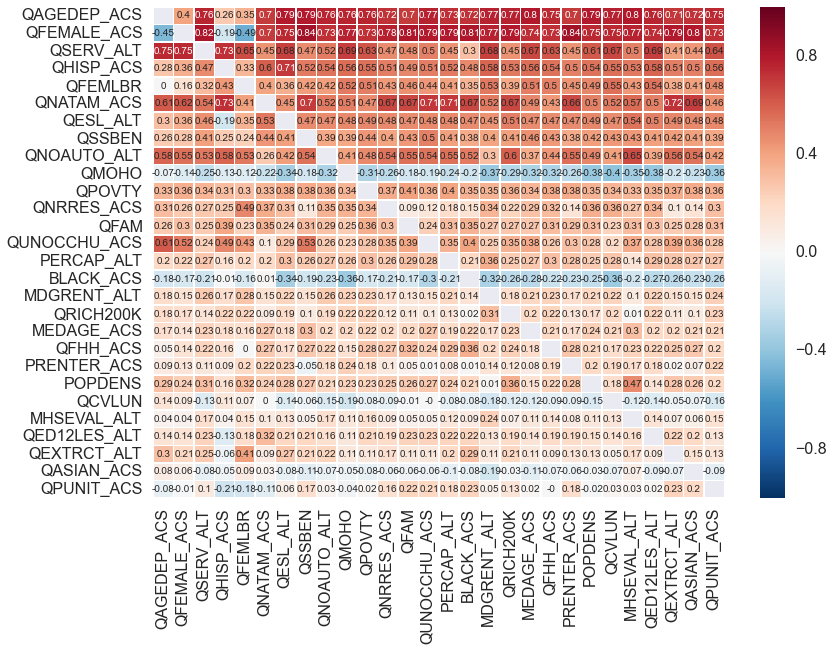

In [119]:
%matplotlib inline
##ORDER INPUT DATA FRAME BY RANK BEFORE ANALYSSIS
sns.set_context("poster")
mask=np.isnan(US_Drop1_NetContrib)
sns.heatmap(US_Drop1_NetContrib, annot=True, linewidths=.25, vmin=-1, vmax=1)
